# Pytorch starter - FasterRCNN Train
In this notebook I enabled the GPU and the Internet access (needed for the pre-trained weights). We can not use Internet during inference, so I'll create another notebook for commiting. Stay tuned!

You can find the [inference notebook here](https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-inference)

- FasterRCNN from torchvision
- Use Resnet50 backbone
- Albumentation enabled (simple flip for now)


In [3]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = '/home/kerrykim/jupyter_notebook/008.wheat_detection/data_origin'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [4]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape

(147793, 5)

In [5]:
train_df

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1
...,...,...,...,...,...
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2


In [6]:
train_df['x'] = -1

In [7]:
train_df

,image_id,width,height,bbox,source,x
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,-1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,-1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,-1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,-1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,-1
...,...,...,...,...,...,...
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2,-1
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2,-1
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2,-1
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2,-1


In [8]:
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

In [9]:
train_df

,image_id,width,height,bbox,source,x,y,w,h
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,-1,-1,-1,-1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,-1,-1,-1,-1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,-1,-1,-1,-1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,-1,-1,-1,-1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2,-1,-1,-1,-1
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2,-1,-1,-1,-1
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2,-1,-1,-1,-1
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2,-1,-1,-1,-1


In [10]:
def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))    #re.find all은 특정한 문자나 숫자를 찾을 때 사용하는 함수
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

In [11]:
example = '92.0, 549.0, 107.0, 82.0'

expand_bbox(example)

array(['92.0', '549.0', '107.0', '82.0'], dtype='<U5')

In [12]:
train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))

In [13]:
train_df

,image_id,width,height,bbox,source,x,y,w,h
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0
...,...,...,...,...,...,...,...,...,...
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2,64.0,619.0,84.0,95.0
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2,292.0,549.0,107.0,82.0
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2,134.0,228.0,141.0,71.0
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2,430.0,13.0,184.0,79.0


In [14]:
train_df.drop(columns=['bbox'], inplace=True)

train_df

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0
...,...,...,...,...,...,...,...,...
147788,5e0747034,1024,1024,arvalis_2,64.0,619.0,84.0,95.0
147789,5e0747034,1024,1024,arvalis_2,292.0,549.0,107.0,82.0
147790,5e0747034,1024,1024,arvalis_2,134.0,228.0,141.0,71.0
147791,5e0747034,1024,1024,arvalis_2,430.0,13.0,184.0,79.0


In [15]:
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

train_df

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0
...,...,...,...,...,...,...,...,...
147788,5e0747034,1024,1024,arvalis_2,64.0,619.0,84.0,95.0
147789,5e0747034,1024,1024,arvalis_2,292.0,549.0,107.0,82.0
147790,5e0747034,1024,1024,arvalis_2,134.0,228.0,141.0,71.0
147791,5e0747034,1024,1024,arvalis_2,430.0,13.0,184.0,79.0


In [17]:
image_ids = train_df['image_id'].unique()    # 중복되는 값이 아니고 유니크한 값만 뽑아냄 즉 사진 데이터는 총 3373장인듯 (실제론 3422장? 같은 이름의 사진이 있는듯)
image_ids.shape

(3373,)

In [18]:
valid_ids = image_ids[-665:]    # 사진(image_id)의 갯수별로 valid train split, 아마도 1/4인듯
train_ids = image_ids[:-665]

valid_ids

array(['bbce58f71', 'b45096c1e', 'b3c96d5ad', '1be796d9d', 'ba9133208',
       'ac891ac35', 'a5904a10b', 'ea0e9e846', '92f3b252f', '59d43a53f',
       '290ae67be', '8afea785a', '44b7163ea', 'd1f73158a', 'fabaeac81',
       'b57f67edf', 'c8defc0d1', '5f5181592', '38b19d4f5', 'f233cfd8b',
       '2391f283f', '07479da31', '5e182e37e', 'ce3999eb9', '03d831c0d',
       'e721e6416', '228f94f80', '4b127eb47', '6f119c82d', 'a6c205e19',
       '2c836cccb', 'f54ff03a2', '09f97e0cf', 'b46dce732', '9658b9c3c',
       'f5b320e47', '6b4169a72', 'f415daf80', '99886a700', '0c2d20111',
       '1b3376c60', '5e30f8f4d', 'ab81b2342', 'abcb46fc1', 'e05767cda',
       'ca664da7d', '93c9d721e', 'f84383b38', '56105ed87', '18df0fea9',
       '14d024cc4', '89fb3f19c', 'aa82bfd6a', '42f5fe6a5', 'd39457b35',
       'b7c9166b6', 'd011146e3', '69e509038', '3ee6fd90a', 'aec95891a',
       '6b8416819', 'c022ddc42', 'a88930f1f', '3b2183a3c', '7ad46c7f4',
       '69a211ccf', '3ae057d35', '7bf6e7991', '16a0dc111', '5a56

In [19]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]    # isin을 쓰면 예전처럼 for문을 써서 하나씩 비교하지 않고 뽑아낼 수 있겠다.
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [20]:
valid_df

,image_id,width,height,source,x,y,w,h
122787,bbce58f71,1024,1024,arvalis_3,430.0,0.0,142.0,75.0
122788,bbce58f71,1024,1024,arvalis_3,255.0,377.0,100.0,69.0
122789,bbce58f71,1024,1024,arvalis_3,788.0,634.0,146.0,77.0
122790,bbce58f71,1024,1024,arvalis_3,344.0,836.0,102.0,110.0
122791,bbce58f71,1024,1024,arvalis_3,217.0,694.0,107.0,85.0
...,...,...,...,...,...,...,...,...
147788,5e0747034,1024,1024,arvalis_2,64.0,619.0,84.0,95.0
147789,5e0747034,1024,1024,arvalis_2,292.0,549.0,107.0,82.0
147790,5e0747034,1024,1024,arvalis_2,134.0,228.0,141.0,71.0
147791,5e0747034,1024,1024,arvalis_2,430.0,13.0,184.0,79.0


In [21]:
train_df

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0
...,...,...,...,...,...,...,...,...
122782,97372d371,1024,1024,arvalis_3,59.0,442.0,61.0,58.0
122783,97372d371,1024,1024,arvalis_3,30.0,517.0,69.0,105.0
122784,97372d371,1024,1024,arvalis_3,0.0,889.0,56.0,121.0
122785,97372d371,1024,1024,arvalis_3,104.0,872.0,84.0,109.0


In [22]:
valid_df.shape, train_df.shape

((25006, 8), (122787, 8))

In [25]:
boxes = [[117.0, 975.0, 87.0, 49.0],[104.0, 872.0, 84.0, 109.0]]
# boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
# boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

boxes[:, 2]

TypeError: list indices must be integers or slices, not tuple

In [28]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0    # albumentation에서 normalize를 사용하지 않음

        boxes = records[['x', 'y', 'w', 'h']].values     # 잘 이해는가지 않지만 df의 x,y,w,h 값을 받는 것 같다.
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    
    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [54]:
records = train_df[train_df['image_id'] == 'b6ab77fd7']
#records

boxes = records[['x', 'y', 'w', 'h']].values

len(boxes)
# label = torch.ones((boxes.shape[0],), dtype=torch.int64)
# label

47

In [29]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


# Create the model

In [30]:
#  COCO로 미리 학솝된 모델 읽기
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [31]:
num_classes = 2  # 1 class (wheat) + background

# # 분류기에서 사용할 입력 특징의 차원 정보를 얻습니다
in_features = model.roi_heads.box_predictor.cls_score.in_features    # Region 방법을 통해서 관심있는 지역을 찾아낸다. Region of interest

# 미리 학습된 모델의 머리 부분을 새로운 것으로 교체합니다
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [32]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [33]:
def collate_fn(batch):
    return tuple(zip(*batch))

# 흥미로운 파라미터는 collate_fn 입니다. collate_fn을 이용하면 샘플을 얼마나 정확하게 배치해야하는지를 설정할 수 있습니다. 
# 하지만 대부분의 경우에도 기본 collate는 제대로 작동합니다.

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [34]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Sample

In [35]:
images, targets, image_ids = next(iter(train_data_loader)) # 첫번째 나오는 iteration의 값을 받아준다. 배치가 4기때문에 이미지 아이디도 4개나옴
image_ids

('b6ab77fd7', 'b53afdf5c', '7b72ea0fb', '91c9d9c38')

In [36]:
images = list(image.to(device) for image in images)
#images

In [38]:
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]   # targets에서 t를 뽑아오면 boxes, labels, image_id, area, iscrowd가 있고 값이 있음.
#targets # 모든 인스턴스는 군중(crowd) 상태가 아님을 가정합니다


# area (Tensor[N]): 바운딩 박스의 면적입니다. 면적은 평가 시 작음,중간,큰 박스 간의 점수를 내기 위한 기준이며 COCO 평가를 기준으로 합니다. 
# iscrowd (UInt8Tensor[N]): 이 값이 참일 경우 평가에서 제외합니다. 

In [39]:
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


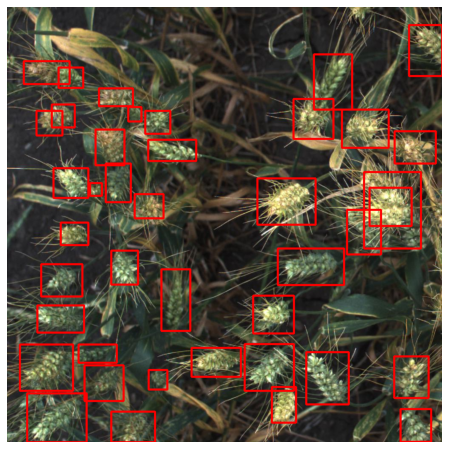

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

# rectangle은 사각형을 그려주는 함수인데 이함수를 써서 빨간색 박스를 그린듯 box[0] ,[ 1], ...은 좌표로 보임
for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

# Train

In [42]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 2

In [43]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        # 한 이미지에 박스가 여러개 있으니까 그걸 썸하는건가??
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

Iteration #50 loss: 0.7779295428312398


KeyboardInterrupt: 

In [35]:
images, targets, image_ids = next(iter(valid_data_loader))

In [36]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [37]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()

In [38]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


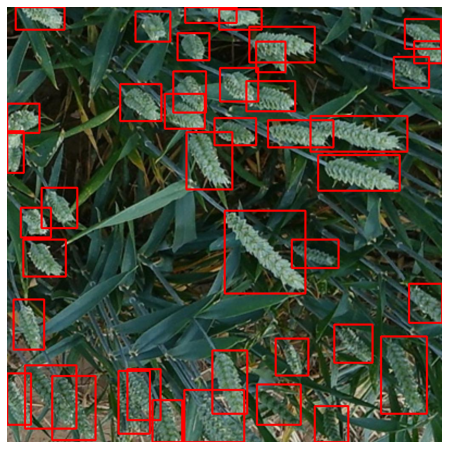

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [40]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')